In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../tacotron2/")
sys.path.insert(0, "../waveglow/")

import librosa
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Audio

from audio.vocoders import griffin_lim
from tacotron2.model import Tacotron2
from tacotron2.text import text_to_sequence, sequence_to_text
from waveglow.glow import WaveGlow

In [2]:
# Tacotron 2
TACOTRON_CONFIG=json.load(open('../tacotron2/config.json', 'r'))
TACOTRON_CHECKPT='../checkpoints/tacotron2_statedict.pt'

# Waveglow
WAVEGLOW_CONFIG=json.load(open('../waveglow/config.json', 'r'))
WAVEGLOW_CHECKPT='../checkpoints/waveglow_256channels_ljs_v3.pt'

# Essential
ON_GPU=False
MAX_WAV_VALUE=32768.0
SIGMA=1.1

___
### **1 Load Tacotron 2**

In [19]:
tacotron2 = Tacotron2(TACOTRON_CONFIG)
checkpt_state_dict = torch.load(TACOTRON_CHECKPT,
                                map_location=lambda storage, loc: storage)['state_dict']
tacotron2.load_state_dict(checkpt_state_dict)
_ = tacotron2.cuda().eval() if ON_GPU else tacotron2.cpu().eval()

print('Number of parameters:', tacotron2.nparams())

Number of parameters: 28193153


___
### **2 SVD of linear layers**

In [20]:
for key in tacotron2.state_dict().keys():
    if 'linear_layer' in key: print(key)

decoder.prenet.layers.0.linear_layer.weight
decoder.prenet.layers.1.linear_layer.weight
decoder.attention_layer.query_layer.linear_layer.weight
decoder.attention_layer.memory_layer.linear_layer.weight
decoder.attention_layer.v.linear_layer.weight
decoder.attention_layer.location_layer.location_dense.linear_layer.weight
decoder.linear_projection.linear_layer.weight
decoder.linear_projection.linear_layer.bias
decoder.gate_layer.linear_layer.weight
decoder.gate_layer.linear_layer.bias


Layers `decoder.attention_layer.v` and `decoder.gate_layer` have size 1!!!

#### **2.1 decoder.prenet**

In [5]:
prenet_linear_0 = tacotron2.decoder.prenet.layers[0]
prenet_linear_1 = tacotron2.decoder.prenet.layers[1]

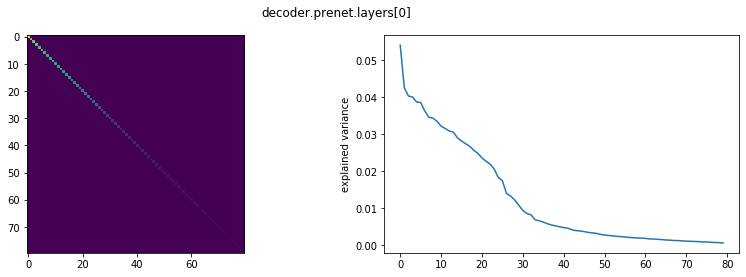

In [6]:
U, s, V = torch.svd(prenet_linear_0.linear_layer.weight.data)

plt.figure(figsize=(14, 4))
plt.suptitle('decoder.prenet.layers[0]')
plt.subplot(1, 2, 1)
plt.imshow(torch.diag(s))
plt.subplot(1, 2, 2)
plt.ylabel('explained variance')
plt.plot(s / s.sum());

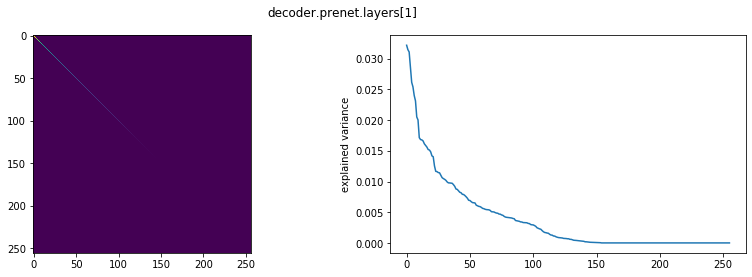

In [7]:
U, s, V = torch.svd(prenet_linear_1.linear_layer.weight.data)

plt.figure(figsize=(14, 4))
plt.suptitle('decoder.prenet.layers[1]')
plt.subplot(1, 2, 1)
plt.imshow(torch.diag(s))
plt.subplot(1, 2, 2)
plt.ylabel('explained variance')
plt.plot(s / s.sum());

#### **2.1 decoder.attention_layer**

In [8]:
attention_query = tacotron2.decoder.attention_layer.query_layer.linear_layer
attention_memory = tacotron2.decoder.attention_layer.memory_layer.linear_layer
attention_location = tacotron2.decoder.attention_layer.location_layer.location_dense.linear_layer

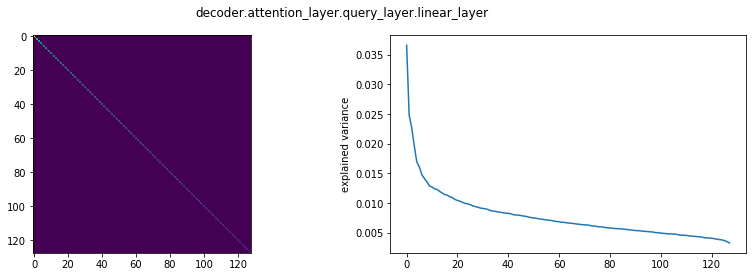

In [9]:
U, s, V = torch.svd(attention_query.weight.data)

plt.figure(figsize=(14, 4))
plt.suptitle('decoder.attention_layer.query_layer.linear_layer')
plt.subplot(1, 2, 1)
plt.imshow(torch.diag(s))
plt.subplot(1, 2, 2)
plt.ylabel('explained variance')
plt.plot(s / s.sum());

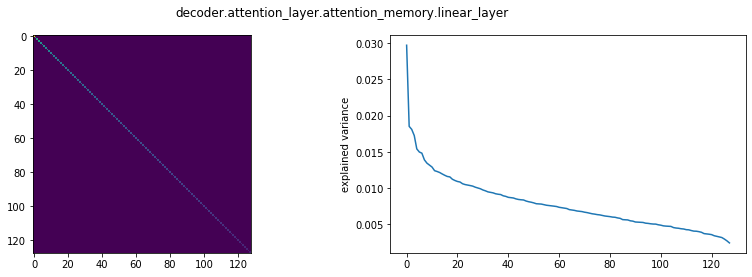

In [10]:
U, s, V = torch.svd(attention_memory.weight.data)

plt.figure(figsize=(14, 4))
plt.suptitle('decoder.attention_layer.attention_memory.linear_layer')
plt.subplot(1, 2, 1)
plt.imshow(torch.diag(s))
plt.subplot(1, 2, 2)
plt.ylabel('explained variance')
plt.plot(s / s.sum());

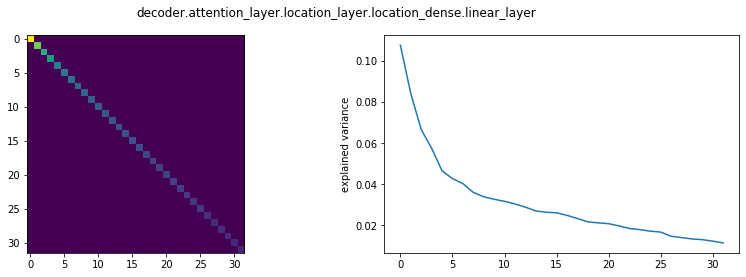

In [11]:
U, s, V = torch.svd(attention_location.weight.data)

plt.figure(figsize=(14, 4))
plt.suptitle('decoder.attention_layer.location_layer.location_dense.linear_layer')
plt.subplot(1, 2, 1)
plt.imshow(torch.diag(s))
plt.subplot(1, 2, 2)
plt.ylabel('explained variance')
plt.plot(s / s.sum());

#### **2.1 Final projection**

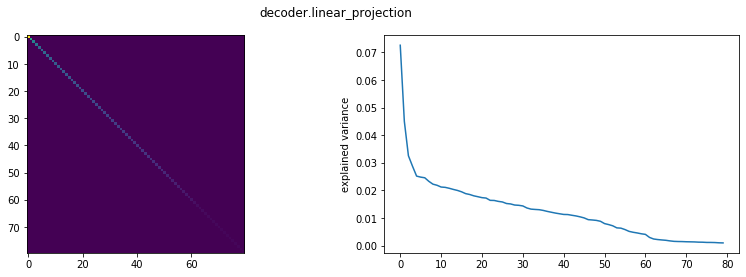

In [12]:
U, s, V = torch.svd(tacotron2.decoder.linear_projection.linear_layer.weight.data)

plt.figure(figsize=(14, 4))
plt.suptitle('decoder.linear_projection')
plt.subplot(1, 2, 1)
plt.imshow(torch.diag(s))
plt.subplot(1, 2, 2)
plt.ylabel('explained variance')
plt.plot(s / s.sum());

___
### **3 Compression**

In [12]:
tacotron2.compress_factorize(explained_variance=0.85)

compressing decoder.prenet.layers.0.linear_layer.weight....Done.
compressing decoder.prenet.layers.1.linear_layer.weight....Done.
compressing decoder.linear_projection.linear_layer.weight..Done.
compressing decoder.gate_layer.linear_layer.weight.. Failed.


In [13]:
tacotron2.nparams()

28087937

In [27]:
tacotron2.decoder.gate_layer.linear_layer.weight.shape

torch.Size([1, 1536])

___
### **4 Inference**
**Load WaveGlow**

In [21]:
waveglow = torch.load(WAVEGLOW_CHECKPT,
                      map_location=lambda storage, loc: storage)['model']
waveglow = waveglow.remove_weightnorm(waveglow)
_ = waveglow.cuda().eval() if ON_GPU else waveglow.cpu().eval()

**Prepare texts**

In [22]:
texts = ["Cristiano Ronaldo has won his first UEFA Champions League with Manchester United in two thousand eight.",
         "Implicit learning of the likelihood makes normalizing flows very strong generative tool.",
         "WaveGlow and L P C Net are accelerated derivatives of WaveNet state-of-the-art model."]
assert len(texts) > 0
texts = [text.strip() for text in texts]
sequences = [np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
             for text in texts]
sequences = [torch.autograd.Variable(torch.from_numpy(sequence)).long()
             for sequence in sequences]

**Synthesis**

In [23]:
USE_WAVEGLOW=False
TEXT_IDX=-1

print(sequence_to_text(map(int, list(sequences[TEXT_IDX].squeeze()))))

total_start = datetime.now()

with torch.no_grad():
    tc_start = datetime.now()
    mel_outputs, mel, gate_outputs, alignments = tacotron2.inference(sequences[TEXT_IDX])
    tc_end = datetime.now()
    
    if USE_WAVEGLOW:
        wg_start = datetime.now()
        wave = MAX_WAV_VALUE*waveglow.infer(mel, sigma=SIGMA)
        wg_end = datetime.now()
    
total_end = datetime.now()
print('Total inference time:', total_end - total_start)
print('Tacotron 2 inference time:', tc_end - tc_start)
if USE_WAVEGLOW: print('Waveglow inference time:', wg_end - wg_start)

waveglow and l p c net are accelerated derivatives of wavenet state-of-the-art model.
Total inference time: 0:00:02.561559
Tacotron 2 inference time: 0:00:02.560559


In [24]:
if USE_WAVEGLOW: Audio(wave, rate=22050)

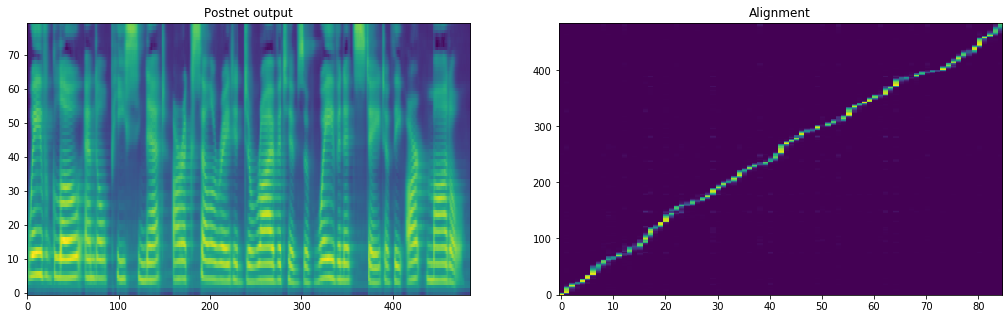

In [25]:
plt.figure(figsize=(27, 5));

plt.subplot(1, 3, 1);
plt.imshow(mel.cpu().squeeze().detach().numpy(), aspect='auto', origin='bottom');
plt.title('Postnet output');

plt.subplot(1, 3, 2);
plt.imshow(alignments.cpu().squeeze().detach().numpy(), aspect='auto', origin='bottom');
plt.title('Alignment');


if USE_WAVEGLOW:
    plt.subplot(1, 3, 3);
    plt.imshow(np.log(librosa.feature.melspectrogram(y=wave.cpu().numpy().squeeze(),
                                                     n_fft=1024, hop_length=256, win_length=1024, n_mels=80)),
               aspect='auto', origin='bottom');
    plt.title('Mel-spectrogram of generated wave');

In [27]:
class TruncatedSVDLinear(torch.nn.Module):
    def __init__(self):
        super(TruncatedSVDLinear, self).__init__()
        self.a = torch.nn.Parameter(torch.Tensor([0]))
        self.b = torch.nn.Parameter(torch.Tensor([0]))
        
class Linear(torch.nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.linear_layer = torch.nn.Linear(2, 2)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = Linear()
        self.linear2 = Linear()
        
    def compress(self, module_name):
        module = getattr(self, module_name)
        module.linear_layer = TruncatedSVDLinear()
        
    def nparams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [30]:
net = Net()
net.nparams()

12

In [31]:
net.compress('linear1')

In [32]:
net

Net(
  (linear1): Linear(
    (linear_layer): TruncatedSVDLinear()
  )
  (linear2): Linear(
    (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [34]:
net.nparams()

8